## Facies classification using KNearestNeighbors (submission 2)
<a rel="license" href="https://creativecommons.org/licenses/by-sa/4.0/">
  <img alt="Creative Commons License BY-SA" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png">
</a>
<br>
##### Dan Hallau
Here is another KNearestNeighbors solution to the facies classification contest described at https://github.com/seg/2016-ml-contest. A lot of sophisticated models have been submitted for the contest so far (deep neural nets, random forests, etc.) so I thought I'd try submitting a simpler model to see how it stacks up. In that spirit here's another KNearestNeighbors classifier.

*Note*: The main differences between my KNN Submission 1 and KNN Submission 2 are:
- In submission 2 I use a KNearestNeighborsRegressor to predict PE in records where there is no data. This gives me much more data with which to train the classifier.
- In submission 1 I excluded the CROSS H CATTLE well from the training set, but in submission 2 I include it.
- In submission 1 I excluded records where PHIND was greater than 40%, but in submission 2 I leave those records in the training set, in case rugose hole is an issue in the validation wells.
- In submission 2 I basically did a bootstrapped grid search to optimize the `n_neighbors` parameter.

I spend a few cells back-calculating some more standard logging curves (RHOB, NPHI, etc), use a KNN regressor to regress missing PE values from other logs, then create a log-based lithology model from a Umaa-Rhomaa plot. After training, I finish it up with a LeaveOneGroupOut test.

In [1]:
import pandas as pd
import numpy as np

from sklearn import neighbors
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut

import inversion

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Load training data

In [2]:
df = pd.read_csv('../facies_vectors.csv')

#### Build features

In the real world it would be unusual to have neutron-density cross-plot porosity (i.e. PHIND) without the corresponding raw input curves, namely bulk density and neutron porosity, as we have in this contest dataset. So as part of the feature engineering process, I back-calculate estimates of those raw curves from the provided DeltaPHI and PHIND curves. One issue with this approach though is that cross-plot porosity differs between vendors, toolstrings, and software packages, and it is not known exactly how the PHIND in this dataset was computed. So I make the assumption here that PHIND ≈ sum of squares porosity, which is usually an adequate approximation of neutron-density crossplot porosity. That equation looks like this: 

$$PHIND ≈ \sqrt{\frac{NPHI^2 + DPHI^2}{2}}$$

and it is assumed here that DeltaPHI is:

$$DeltaPHI = NPHI - DPHI$$

The functions below use the relationships from the above equations (...two equations, two unknowns...) to estimate NPHI and DPHI (and consequently RHOB).

Once we have RHOB, we can use it combined with PE to estimate apparent grain density (RHOMAA) and apparent photoelectric capture cross-section (UMAA), which are useful in lithology estimations from well logs.

In [3]:
def estimate_dphi(df):
    return ((4*(df['PHIND']**2) - (df['DeltaPHI']**2))**0.5 - df['DeltaPHI']) / 2

def estimate_rhob(df):
    return (2.71 - (df['DPHI_EST']/100) * 1.71)

def estimate_nphi(df):
    return df['DPHI_EST'] + df['DeltaPHI']

def compute_rhomaa(df):
    return (df['RHOB_EST'] - (df['PHIND'] / 100)) / (1 - df['PHIND'] / 100)
            
def compute_umaa(df):
    return ((df['PE'] * df['RHOB_EST']) - (df['PHIND']/100 * 0.398)) / (1 - df['PHIND'] / 100)

Because solving the sum of squares equation involved the quadratic formula, in some cases imaginary numbers result due to porosities being negative, which is what the warning below is about.

In [4]:
df['DPHI_EST'] = df.apply(lambda x: estimate_dphi(x), axis=1).astype(float)
df['RHOB_EST'] = df.apply(lambda x: estimate_rhob(x), axis=1)
df['NPHI_EST'] = df.apply(lambda x: estimate_nphi(x), axis=1)
df['RHOMAA_EST'] = df.apply(lambda x: compute_rhomaa(x), axis=1)

/home/delta/anaconda3/lib/python3.5/site-packages/pandas/core/common.py:1920: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype)


#### Regress missing PE values

In [5]:
pe = df.dropna()

PE = pe['PE'].values
wells = pe['Well Name'].values

drop_list_pe = ['Formation', 'Well Name', 'Facies', 'Depth', 'PE', 'RELPOS'] 

fv_pe = pe.drop(drop_list_pe, axis=1).values

X_pe = preprocessing.StandardScaler().fit(fv_pe).transform(fv_pe)
y_pe = PE

reg = neighbors.KNeighborsRegressor(n_neighbors=40, weights='distance')

logo = LeaveOneGroupOut()
f1knn_pe = []

for train, test in logo.split(X_pe, y_pe, groups=wells):
    well_name = wells[test[0]]
    reg.fit(X_pe[train], y_pe[train])
    score = reg.fit(X_pe[train], y_pe[train]).score(X_pe[test], y_pe[test])
    print("{:>20s}  {:.3f}".format(well_name, score))
    f1knn_pe.append(score)
    
print("-Average leave-one-well-out F1 Score: %6f" % (np.mean(f1knn_pe)))

     CHURCHMAN BIBLE  0.710
      CROSS H CATTLE  0.665
            LUKE G U  0.547
               NEWBY  0.401
               NOLAN  0.534
          Recruit F9  0.794
             SHANKLE  0.380
           SHRIMPLIN  0.241
-Average leave-one-well-out F1 Score: 0.534165


Apply regression model to missing PE values and merge back into dataframe:

In [6]:
reg.fit(X_pe, y_pe)
fv_apply = df.drop(drop_list_pe, axis=1).values
X_apply = preprocessing.StandardScaler().fit(fv_apply).transform(fv_apply)
df['PE_EST'] = reg.predict(X_apply)
df.PE = df.PE.combine_first(df.PE_EST)

Compute UMAA for lithology model

In [7]:
df['UMAA_EST'] = df.apply(lambda x: compute_umaa(x), axis=1)

Just for fun, below is a basic Umaa-Rhomaa plot to view relative abundances of quartz, calcite, dolomite, and clay. The red triangle represents a ternary solution for QTZ, CAL, and DOL, while the green triangle represents a solution for QTZ, CAL, and CLAY (illite). 

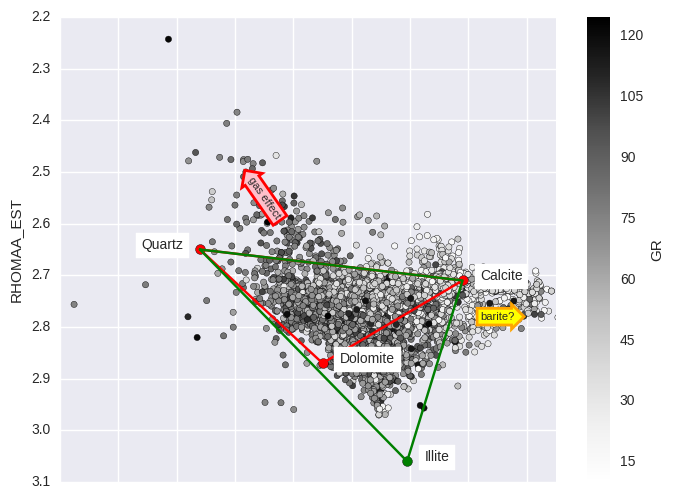

In [8]:
df[df.GR < 125].plot(kind='scatter', x='UMAA_EST', y='RHOMAA_EST', c='GR', figsize=(8,6))
plt.ylim(3.1, 2.2)
plt.xlim(0.0, 17.0)
plt.plot([4.8, 9.0, 13.8, 4.8], [2.65, 2.87, 2.71, 2.65], c='r')
plt.plot([4.8, 11.9, 13.8, 4.8], [2.65, 3.06, 2.71, 2.65], c='g')
plt.scatter([4.8], [2.65], s=50, c='r')
plt.scatter([9.0], [2.87], s=50, c='r')
plt.scatter([13.8], [2.71], s=50, c='r')
plt.scatter([11.9], [3.06], s=50, c='g')
plt.text(2.8, 2.65, 'Quartz', backgroundcolor='w')
plt.text(14.4, 2.71, 'Calcite', backgroundcolor='w')
plt.text(9.6, 2.87, 'Dolomite', backgroundcolor='w')
plt.text(12.5, 3.06, 'Illite', backgroundcolor='w')
plt.text(7.0, 2.55, "gas effect", ha="center", va="center", rotation=-55,
            size=8, bbox=dict(boxstyle="larrow,pad=0.3", fc="pink", ec="red", lw=2))
plt.text(15.0, 2.78, "barite?", ha="center", va="center", rotation=0,
            size=8, bbox=dict(boxstyle="rarrow,pad=0.3", fc="yellow", ec="orange", lw=2))

Here I use matrix inversion to "solve" the ternary plot for each lithologic component. Essentially each datapoint is a mix of the three components defined by the ternary diagram, with abundances of each defined by the relative distances from each endpoint. I use a GR cutoff of 40 API to determine when to use either the QTZ-CAL-DOL or QTZ-CAL-CLAY ternary solutions. In other words, it is assumed that below 40 API, there is 0% clay, and above 40 API there is 0% dolomite, and also that these four lithologic components are the only components in these rocks. Admittedly it's not a great assumption, especially since the ternary plot indicates other stuff is going on. For example the high Umaa datapoints near the Calcite endpoint may indicate some heavy minerals (e.g., pyrite) or even barite-weighted mud. The "pull" of datapoints to the northwest quadrant probably reflects some gas effect, so my lithologies in those gassy zones will be skewed.

In [9]:
# QTZ-CAL-CLAY
ur1 = inversion.UmaaRhomaa()
ur1.set_dol_uma(11.9)
ur1.set_dol_rhoma(3.06)
# QTZ-CAL-DOL
ur2 = inversion.UmaaRhomaa()

df['UR_QTZ'] = np.nan
df['UR_CLY'] = np.nan
df['UR_CAL'] = np.nan
df['UR_DOL'] = np.nan

df.ix[df.GR >= 40, 'UR_QTZ'] = df.ix[df.GR >= 40].apply(lambda x: ur1.get_qtz(x.UMAA_EST, x.RHOMAA_EST), axis=1)
df.ix[df.GR >= 40, 'UR_CLY'] = df.ix[df.GR >= 40].apply(lambda x: ur1.get_dol(x.UMAA_EST, x.RHOMAA_EST), axis=1) 
df.ix[df.GR >= 40, 'UR_CAL'] = df.ix[df.GR >= 40].apply(lambda x: ur1.get_cal(x.UMAA_EST, x.RHOMAA_EST), axis=1)
df.ix[df.GR >= 40, 'UR_DOL'] = 0

df.ix[df.GR < 40, 'UR_QTZ'] = df.ix[df.GR < 40].apply(lambda x: ur2.get_qtz(x.UMAA_EST, x.RHOMAA_EST), axis=1)
df.ix[df.GR < 40, 'UR_DOL'] = df.ix[df.GR < 40].apply(lambda x: ur2.get_dol(x.UMAA_EST, x.RHOMAA_EST), axis=1) 
df.ix[df.GR < 40, 'UR_CAL'] = df.ix[df.GR < 40].apply(lambda x: ur2.get_cal(x.UMAA_EST, x.RHOMAA_EST), axis=1)
df.ix[df.GR < 40, 'UR_CLY'] = 0

Below I train the model using 1 to 599 `n_neighbors` and select a value for `n_neighbors` to use in my classifier with a high average on the LOGO test. In this case I will use 62. I recommend not running this cell as it takes a while to complete.

In [10]:
#score_list = []
#for i in range(1,600):
#    clf = neighbors.KNeighborsClassifier(n_neighbors=i, weights='distance')
#    f1knn = []
#
#    for train, test in logo.split(X, y, groups=wells):
#        well_name = wells[test[0]]
#        clf.fit(X[train], y[train])
#        score = clf.fit(X[train], y[train]).score(X[test], y[test])
#        #print("{:>20s}  {:.3f}".format(well_name, score))
#        f1knn.append(score)
#        
#    score_list.append([i, np.mean(f1knn)])
#
#score_list

#### Fit KNearestNeighbors model and apply LeaveOneGroupOut test

There is some bad log data in this dataset which I'd guess is due to rugose hole. PHIND gets as high at 80%, which is certainly spurious. For now I'll leave them in, since the validation wells may have rugose hole, too. 

In [11]:
facies = df['Facies'].values
wells = df['Well Name'].values

drop_list = ['Formation', 'Well Name', 'Facies', 'Depth', 'DPHI_EST',  'NPHI_EST', 'DeltaPHI',
             'RHOMAA_EST', 'UMAA_EST', 'UR_QTZ', 'UR_DOL', 'PE'] 

fv = df.drop(drop_list, axis=1).values
X = preprocessing.StandardScaler().fit(fv).transform(fv)
y = facies

clf = neighbors.KNeighborsClassifier(n_neighbors=62, weights='distance') 

logo = LeaveOneGroupOut()

f1knn = []

for train, test in logo.split(X, y, groups=wells):
    well_name = wells[test[0]]
    clf.fit(X[train], y[train])
    score = clf.fit(X[train], y[train]).score(X[test], y[test])
    print("{:>20s}  {:.3f}".format(well_name, score))
    f1knn.append(score)
    
print("-Average leave-one-well-out F1 Score: %6f" % (np.mean(f1knn)))
f1knn.pop(7)
print("-Average leave-one-well-out F1 Score, no Recruit F1: %6f" % (np.mean(f1knn)))

         ALEXANDER D  0.586
     CHURCHMAN BIBLE  0.559
      CROSS H CATTLE  0.407
            KIMZEY A  0.522
            LUKE G U  0.573
               NEWBY  0.501
               NOLAN  0.554
          Recruit F9  0.887
             SHANKLE  0.543
           SHRIMPLIN  0.552
-Average leave-one-well-out F1 Score: 0.568498
-Average leave-one-well-out F1 Score, no Recruit F1: 0.533053


On average the scores are slightly worse than in my KNN_submission_1 model, but that is partially because this time I've included the CROSS H CATTLE well, which performs markedly worse than the other LOGO cases. I am hoping that since the scores for several of the wells have increased, the performance of this model against the validation data will improve.

#### Apply model to validation dataset
Load validation data (vd), build features, and use the classfier from above to predict facies. Ultimately the PE_EST curve seemed to be slightly more predictive than the PE curve proper (?). I use that instead of PE in the classifer so I need to compute it with the validation data.

In [12]:
clf.fit(X, y)

vd = pd.read_csv('../validation_data_nofacies.csv')

vd['DPHI_EST'] = vd.apply(lambda x: estimate_dphi(x), axis=1).astype(float)
vd['RHOB_EST'] = vd.apply(lambda x: estimate_rhob(x), axis=1)
vd['NPHI_EST'] = vd.apply(lambda x: estimate_nphi(x), axis=1)
vd['RHOMAA_EST'] = vd.apply(lambda x: compute_rhomaa(x), axis=1)

drop_list_vd = ['Formation', 'Well Name', 'Depth', 'PE', 'RELPOS'] 
fv_vd = vd.drop(drop_list_vd, axis=1).values
X_vd = preprocessing.StandardScaler().fit(fv_vd).transform(fv_vd)
vd['PE_EST'] = reg.predict(X_vd)
vd.PE = vd.PE.combine_first(vd.PE_EST)

vd['UMAA_EST'] = vd.apply(lambda x: compute_umaa(x), axis=1)

vd['UR_QTZ'] = np.nan
vd['UR_CLY'] = np.nan
vd['UR_CAL'] = np.nan
vd['UR_DOL'] = np.nan

vd.ix[vd.GR >= 40, 'UR_QTZ'] = vd.ix[vd.GR >= 40].apply(lambda x: ur1.get_qtz(x.UMAA_EST, x.RHOMAA_EST), axis=1)
vd.ix[vd.GR >= 40, 'UR_CLY'] = vd.ix[vd.GR >= 40].apply(lambda x: ur1.get_dol(x.UMAA_EST, x.RHOMAA_EST), axis=1) 
vd.ix[vd.GR >= 40, 'UR_CAL'] = vd.ix[vd.GR >= 40].apply(lambda x: ur1.get_cal(x.UMAA_EST, x.RHOMAA_EST), axis=1)
vd.ix[vd.GR >= 40, 'UR_DOL'] = 0

vd.ix[vd.GR < 40, 'UR_QTZ'] = vd.ix[vd.GR < 40].apply(lambda x: ur2.get_qtz(x.UMAA_EST, x.RHOMAA_EST), axis=1)
vd.ix[vd.GR < 40, 'UR_DOL'] = vd.ix[vd.GR < 40].apply(lambda x: ur2.get_dol(x.UMAA_EST, x.RHOMAA_EST), axis=1) 
vd.ix[vd.GR < 40, 'UR_CAL'] = vd.ix[vd.GR < 40].apply(lambda x: ur2.get_cal(x.UMAA_EST, x.RHOMAA_EST), axis=1)
vd.ix[vd.GR < 40, 'UR_CLY'] = 0

drop_list1 = ['Formation', 'Well Name', 'Depth', 'DPHI_EST',  'NPHI_EST', 'DeltaPHI',
             'RHOMAA_EST', 'UMAA_EST', 'UR_QTZ', 'UR_DOL', 'PE'] 

fv_vd1 = vd.drop(drop_list1, axis=1).values
X_vd1 = preprocessing.StandardScaler().fit(fv_vd1).transform(fv_vd1)
vd_predicted_facies = clf.predict(X_vd1)

In [13]:
vd_predicted_facies

array([2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 8, 8, 8,
       8, 8, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 4, 4, 4,
       5, 5, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 6, 6,
       6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 8, 8, 8, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 6, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8,
       8, 8, 6, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 6, 8, 8, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 8, 8, 6, 6, 6, 6, 8, 6, 2, 3, 3,
       3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 8, 8, 8, 8,
       8, 8, 8, 6, 6, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 8, 3, 3, 3, 3, 8, 8, 8, 8,
       8, 3,